In [1]:
import numpy as np
import tensorflow as tf
import utils
from tictactoegame import TicTacToe as Board
from tictactoegame import Player
from tictactoegame import RandomMoves
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os

2024-09-03 15:53:48.993292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [64]:
class Agent(Player):
    def __init__(self,c,policy=None):
        if policy is None:
            policy = tf.keras.Sequential([tf.keras.layers.Dense(64,activation='relu') for i in range(2)]+
                                        [tf.keras.layers.Dense(9,activation='softmax')])
        super().__init__(c)
        self.policy = policy # <-- policy is a Keras model taking 3x3 array to 1x9 array of probabilities
        self.policy.build((None,18))
    
    @tf.function
    def __call__(self, st): # <-- st has shape (batch, 18)
        return self.policy(st)
    
    def makeMove(self, board):
        actions = self.getAvailPosn(board)
        if len(actions)==0:
            return False
        st = utils.board_to_features(board.board)
        st = st.T
        pA = tf.squeeze(self.policy(st))
        action = np.random.choice(9, p=pA.numpy())
        coord = divmod(action,3)
        if board.board[coord[0],coord[1]] != 0: 
            board.board[coord[0],coord[1]]=9
            return action
        board.setPiece(coord, self.c)
        return action

class Session():
    def __init__(self,X=None,O=None,lr=1e-3,gamma=0.8, t_it=10):
        self.history={'wr':[], 'lr':[], 'dr':[], 'ir':[]}
        self.t_it=t_it
        self.it=0 
        
        self.lr=lr
        self.gamma=gamma
        self.discount=tf.constant([gamma**(gamma-t-1) for t in range(8)],dtype=tf.float32)
        self.Xs = X if X is not None else RandomMoves(1)
        self.Os = O if O is not None else RandomMoves(-1)
        self.board = Board()
        self.opt=tf.keras.optimizers.Adam(-1*lr)
        self.hasGenerator=False
        self.hasDataset=False
        
    def get_data_gen(self):
        if self.hasGenerator==True:
            return self.data_gen
        def data_generator():
            while True:
                S,A=[],[]
                for st,at in self:
                    S.append(st)
                    A.append(at)
                S=tf.concat(S,axis=0)
                A=tf.stack(A,axis=0)
                yield (S,A),self.get_reward()
        self.data_gen=data_generator
        self.hasGenerator=True
        return self.data_gen
    
    def getDataset(self):
        if self.hasDataset==True:
            return self.dataset
        self.dataset=tf.data.Dataset.from_generator(self.get_data_gen(),output_signature=((tf.TensorSpec(shape=[None,18],dtype=tf.int32),
                                                                        tf.TensorSpec(shape=[None],dtype=tf.int32)),tf.TensorSpec(shape=None)))
        self.hasDataset=True
        return self.dataset
    
    
    @tf.function
    def get_pg(self,S,A,V):
        A = tf.one_hot(A,depth=9)
        idxs = tf.where(A)
        with tf.GradientTape() as tape:
            P = self.Xs(S)
            P = tf.gather_nd(P,idxs)
            logP = tf.math.log(P)
            logP = tf.reduce_sum(logP*V)
        grads = tape.gradient(logP, self.Xs.policy.variables)
        return grads
    
    
    @tf.function
    def train_step(self,S,A,V,batch_size=10):
        grads = self.get_pg(S,A,V)
        aveG=[g / batch_size for g in grads]
        self.opt.apply_gradients(list(zip(aveG,self.Xs.policy.variables)))
        return tf.reduce_sum(V / batch_size)
    
    def train_loop(self,epochs,batch_size):
        epoch=0
        aveR=[]
        while epoch < epochs:
            print(epoch)
            clear_output(wait=True)
            
            S_,A_,V = [],[],[]
            for (S,A),r in self.getDataset().take(batch_size):
                length=tf.shape(S)[0]
                S_.append(S)
                A_.append(A)
                V.append(tf.stack(self.discount[:length]*r, axis=0))
            S_ = tf.concat(S_,axis=0)
            A_ = tf.concat(A_,axis=0)
            V = tf.concat(V,axis=0)
                
            aveR.append(self.train_step(S_,A_,V,batch_size))
            epoch+=1
        return aveR
        
    def get_reward(self):
        if self.board.isGameOver(1):
            return 1
        if self.board.isGameOver(-1):
            return -1
        if 9 in self.board.board:
            return -1
        if len(self.board.getPosns(0))==0:
            return 0
        return 0
        
    def __iter__(self): # <-- only record Xs moves, for now.
        self.board.reset()
        if self.it % self.t_it == 0:
            for key in self.history:
                self.history[key].append(0)
        self.it+=1
        return self
    
    def __next__(self):
        if self.board.isGameOver(1):
            self.history['wr'][-1] += 1/self.t_it
            raise StopIteration
        if self.board.isGameOver(-1):
            self.history['lr'][-1] += 1/self.t_it
            raise StopIteration
        if len(self.board.getPosns(9))!=0:
            self.history['ir'][-1] += 1/self.t_it
            raise StopIteration
        elif len(self.board.getPosns(0)) == 0:
            self.history['dr'][-1] += 1/self.t_it
            raise StopIteration
        else:
            st,at = utils.board_to_features(self.board.board).T, self.Xs.makeMove(self.board)
            if self.board.isGameOver(1) or len(self.board.getPosns(9))!=0:
                return st,at
            self.Os.makeMove(self.board)
            return st,at

In [72]:
batch_size=15
sess=Session(X=Agent(1),lr=3e-4,t_it=batch_size)

In [77]:
returns=[]

In [111]:
aveR=sess.train_loop(50,batch_size)
returns+=aveR

49


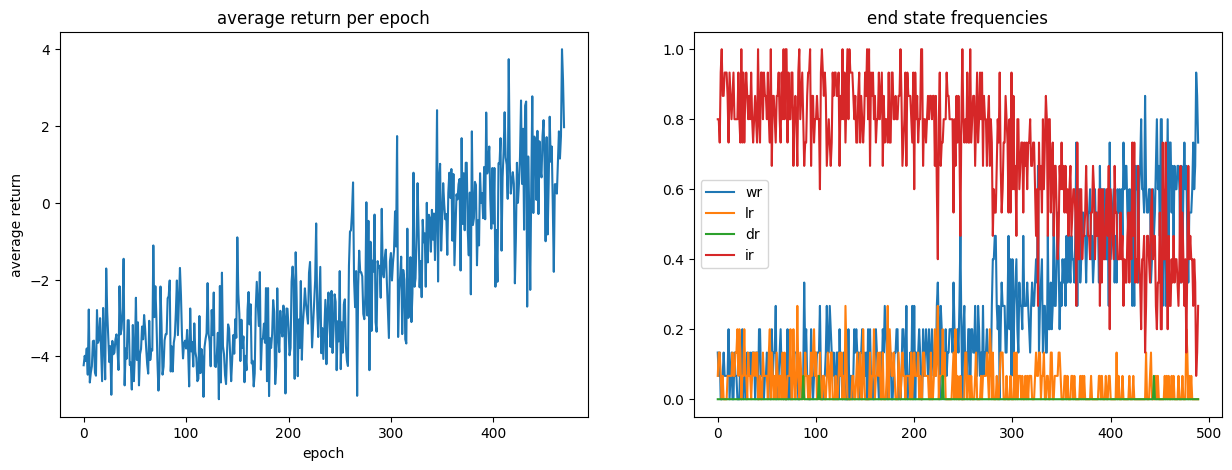

In [113]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(returns)
ax[0].set_title('average return per epoch')
ax[0].set_ylabel('average return')
ax[0].set_xlabel('epoch')

ax[1].set_title('end state frequencies')
for key in sess.history:
    ax[1].plot(sess.history[key],label=key)

ax[1].legend()
    
plt.show()

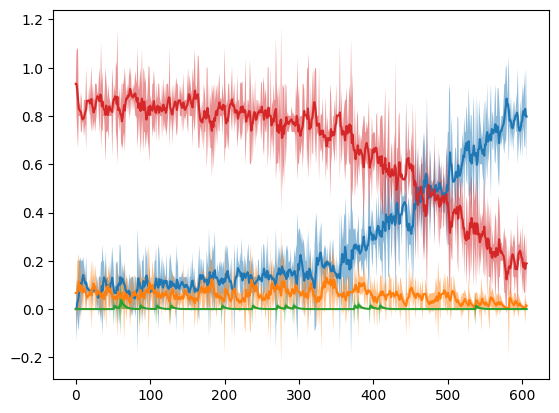

In [67]:
for key in sess.history:
    ema=[sess.history[key][0]]
    for p in sess.history[key]:
        ema.append(0.2*p + 0.8*ema[-1])

    ema=np.array(ema[:-1])

    err=np.abs(np.array(sess.history[key])-ema)

    errmx=[]
    errmn=[]
    mnptr=ema[0]
    mxptr=ema[0]
    for p in sess.history[key]:
        mnptr=min(mnptr,p)
        mxptr=max(mxptr,p)
        errmx.append(mxptr)
        errmn.append(mnptr)

    plt.fill_between(np.arange(0,len(sess.history[key])),ema-err, ema+err,alpha=0.5,linewidth=0)
    plt.plot(ema)

In [23]:
wins=0
losses=0
draws=0
for (S,A),r in sess.dataset.take(100):
    if r==1:
        wins+=1
    elif r==-1:
        losses+=1
    else:
        draw+=1

print(wins/100,losses/100,draws/100)

0.34 0.66 0.0


In [140]:
for i in sess:
    print(sess.board.board)

[[-1  0  0]
 [ 0  0  0]
 [ 0  0  1]]
[[-1  0 -1]
 [ 0  1  0]
 [ 0  0  1]]
[[-1  0 -1]
 [ 0  9  0]
 [ 0  0  1]]


In [91]:
sess.Xs.policy.save_weights('./X_weights')

In [118]:
P0=sess.Xs.policy(np.zeros((1,18)))

In [119]:
P0=tf.reshape(P0,(3,3))

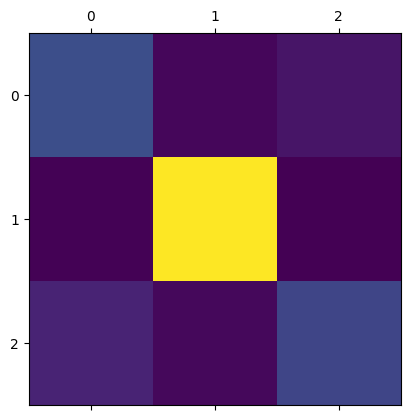

In [120]:
plt.matshow(P0)